<a href="https://colab.research.google.com/github/Kenil-Sutariya/cubecrops-ml-lab-project/blob/main/colab%20notebooks/Full_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import glob
import os
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from PIL import Image
from tensorflow.keras.models import load_model
import torch


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
def last_google_drive_image(printing=True):

    list_of_files = glob.glob('/content/drive/MyDrive/Images/*')

    if not list_of_files:
        print("No images found in the directory.")
        return None

    latest_file = max(list_of_files, key=os.path.getctime)

    image = imageio.imread(latest_file)

    plt.imshow(image)
    plt.axis("off")

    if printing:
        plt.show()

    return image


In [ ]:
def detect_leaves(image, printing=True):

    yolo_model = YOLO("/content/drive/MyDrive/Models/LeafBoxBounding.pt")

    results = yolo_model.predict(image, conf=0.3)

    boxes = results[0].boxes.xyxy

    if isinstance(boxes, torch.Tensor):
        boxes = boxes.cpu().numpy()

    result = results[0]
    image_with_boxes = result.plot()

    plt.imshow(image_with_boxes)
    plt.axis('off')

    if printing:
        plt.show()

    return boxes


In [ ]:
def extract_colored_tiles(image_rgb, bboxes, tile_size=5, threshold=0.8):

    yellow_lower = np.array([20, 100, 100])
    yellow_upper = np.array([40, 255, 255])
    green_lower = np.array([35, 50, 50])
    green_upper = np.array([85, 255, 255])

    hsv_image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)

    extracted_images = []

    for idx, (x1, y1, x2, y2) in enumerate(bboxes):
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])

        bbox_image = image_rgb[y1:y2, x1:x2]
        bbox_hsv = hsv_image[y1:y2, x1:x2]

        valid_tiles = []

        h, w = bbox_hsv.shape[:2]
        for i in range(0, max(1, h - tile_size), tile_size):
            for j in range(0, max(1, w - tile_size), tile_size):
                tile = bbox_hsv[i:i+tile_size, j:j+tile_size]

                yellow_mask = cv2.inRange(tile, yellow_lower, yellow_upper)
                green_mask = cv2.inRange(tile, green_lower, green_upper)

                combined_mask = cv2.bitwise_or(yellow_mask, green_mask)

                percentage = np.sum(combined_mask > 0) / (tile_size * tile_size)

                if percentage >= threshold:
                    valid_tiles.append(bbox_image[i:i+tile_size, j:j+tile_size])

        if valid_tiles:
            num_tiles = len(valid_tiles)
            grid_cols = int(math.ceil(math.sqrt(num_tiles)))
            grid_rows = int(math.ceil(num_tiles / grid_cols))

            rows = []
            for i in range(0, num_tiles, grid_cols):
                row_tiles = valid_tiles[i:i+grid_cols]

                while len(row_tiles) < grid_cols:
                    row_tiles.append(np.zeros((tile_size, tile_size, 3), dtype=np.uint8))

                rows.append(np.concatenate(row_tiles, axis=1))

            extracted_image = np.concatenate(rows, axis=0)
        else:
            extracted_image = np.zeros((50, 50, 3), dtype=np.uint8)

        extracted_images.append(extracted_image)

    return extracted_images


In [ ]:
def predict_pigment_values(extracted_images):

    cnn_model = load_model("/content/drive/MyDrive/Models/PigmentAnalysis.keras")

    predictions = []

    for img in extracted_images:
        if img.size == 0:
            predictions.append([0, 0, 0, 0])
            continue

        img_resized = cv2.resize(img, (128, 128))

        img_resized = img_resized / 255.0

        img_resized = np.expand_dims(img_resized, axis=0)

        pigment_values = cnn_model.predict(img_resized)

        predictions.append(pigment_values[0])

    return predictions




In [ ]:
def analyze_pigment_predictions(predictions):

    predictions = np.array(predictions)

    if predictions.size == 0:
        print("No predictions available.")
        return None

    avg_pigments = np.mean(predictions, axis=0)

    pigment_labels = ['Chlorophyll A', 'Chlorophyll B', 'Anthocyanins', 'Carotenoids']


    plt.figure(figsize=(10, 5))
    for i, pigment_vals in enumerate(predictions):
        plt.plot(pigment_labels, pigment_vals, marker='o', label=f"Bounding Box {i+1}")

    plt.xlabel("Pigments")
    plt.ylabel("Pigment Value")
    plt.title("Pigment Values Across Bounding Boxes")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.bar(pigment_labels, avg_pigments, color=["blue", "green", "red", "purple"])
    plt.xlabel("Pigments")
    plt.ylabel("Average Pigment Value")
    plt.title("Average Pigment Values")
    plt.show()

    print(f"Average Pigment Values: {avg_pigments}")

    return avg_pigments


In [ ]:
def visualize_pigment_analysis():


    image = last_google_drive_image(printing=False)

    bounded_boxes_for_leaves = detect_leaves(image, printing=False)

    extracted_images = extract_colored_tiles(image, bounded_boxes_for_leaves)

    pigment_predictions = predict_pigment_values(extracted_images)

    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.title("Original Image")
    plt.show()

    yolo_model = YOLO("/content/drive/MyDrive/Models/LeafBoxBounding.pt")
    results = yolo_model.predict(image, conf=0.3)
    image_with_boxes = results[0].plot()

    plt.figure(figsize=(6, 6))
    plt.imshow(image_with_boxes)
    plt.axis("off")
    plt.title("Image with Detected Leaves (Bounding Boxes)")
    plt.show()

    for idx, (bbox, extracted_img, pigments) in enumerate(zip(bounded_boxes_for_leaves, extracted_images, pigment_predictions)):

        x1, y1, x2, y2 = map(int, bbox)
        bbox_image = image[y1:y2, x1:x2]

        plt.figure(figsize=(4, 4))
        plt.imshow(bbox_image)
        plt.axis("off")
        plt.title(f"Bounding Box {idx+1}")
        plt.show()

        plt.figure(figsize=(4, 4))
        plt.imshow(extracted_img)
        plt.axis("off")
        plt.title(f"Extracted Tiles for Bounding Box {idx+1}")
        plt.show()

        print(f"Pigment values for Bounding Box {idx+1}: {pigments}")




0: 480x640 72 one leafs, 957.4ms
Speed: 6.7ms preprocess, 957.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51m

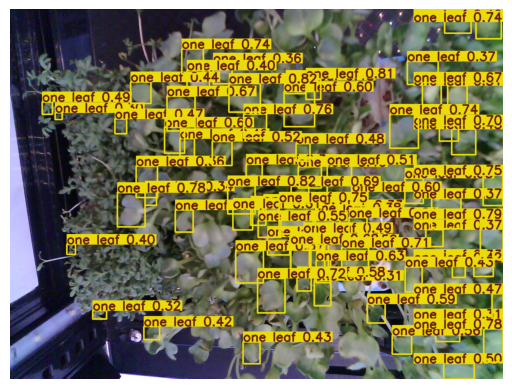

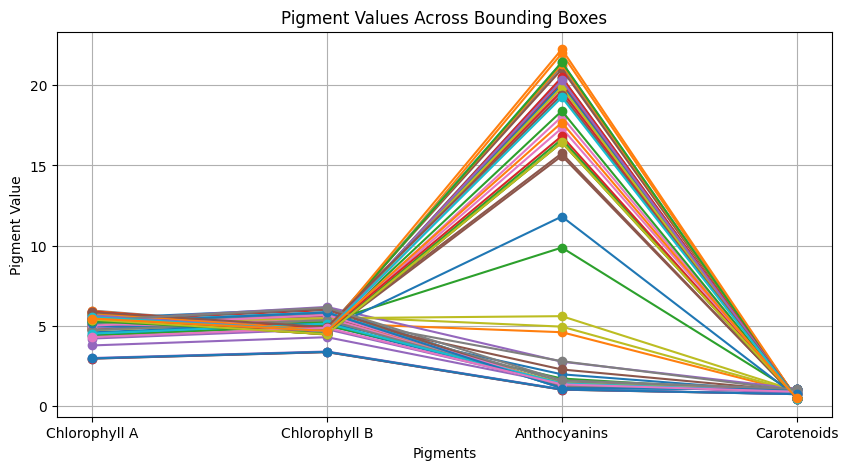

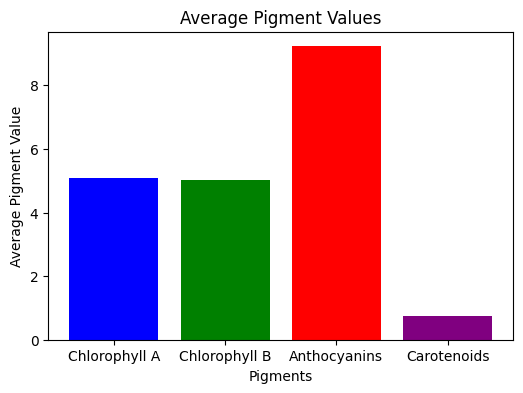

Average Pigment Values: [      5.085      5.0193      9.2244     0.73881]


In [ ]:
results = analyze_pigment_predictions(predictions = predict_pigment_values(extracted_images=extract_colored_tiles(image_rgb=last_google_drive_image(printing = False), bboxes=detect_leaves(image = last_google_drive_image(printing=False), printing = False))))



0: 480x640 72 one leafs, 1553.4ms
Speed: 15.7ms preprocess, 1553.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

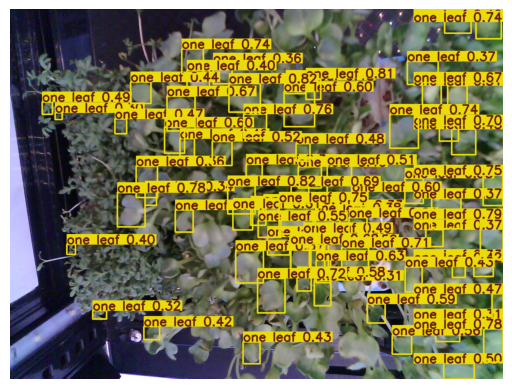

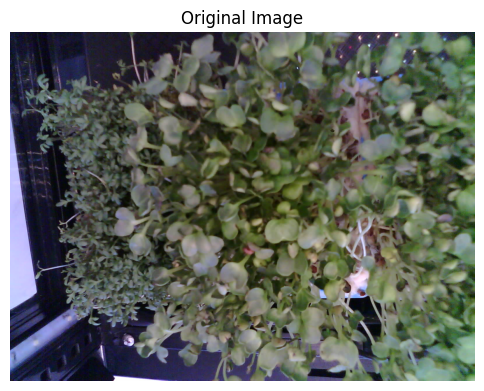


0: 480x640 72 one leafs, 1332.8ms
Speed: 11.1ms preprocess, 1332.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


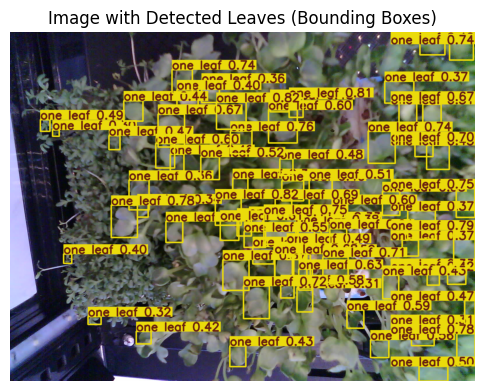

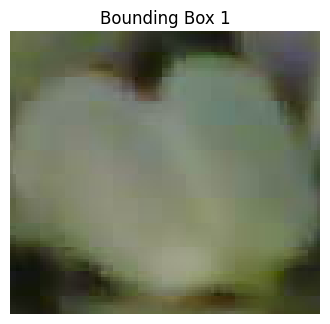

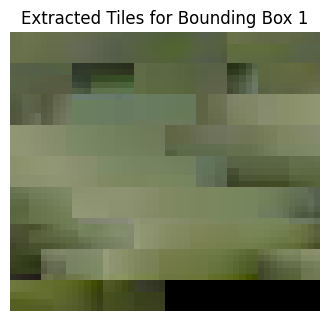

Pigment values for Bounding Box 1: [     5.4571      6.1054      1.2086      1.0555]


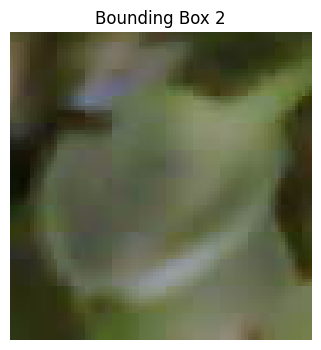

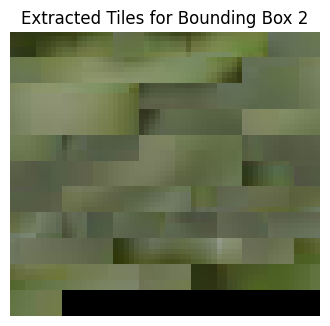

Pigment values for Bounding Box 2: [     4.7733      5.1611      4.6005     0.85241]


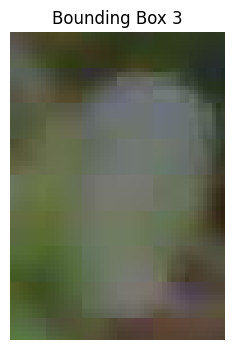

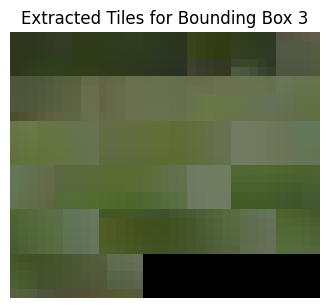

Pigment values for Bounding Box 3: [     5.4314      4.4667      20.434     0.43827]


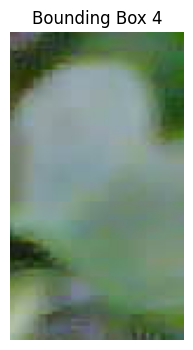

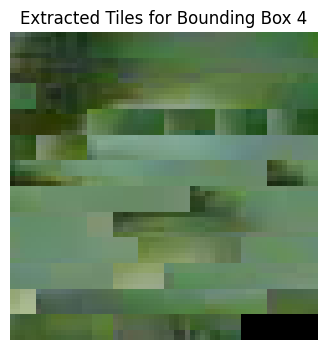

Pigment values for Bounding Box 4: [     4.8808      5.5287      1.3508     0.95868]


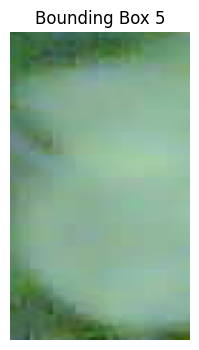

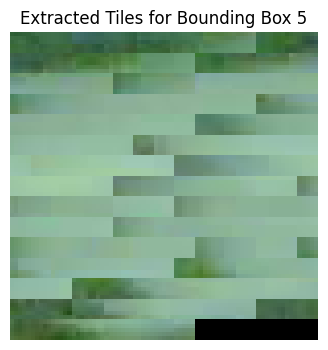

Pigment values for Bounding Box 5: [     4.2061      4.7866      1.3797     0.87457]


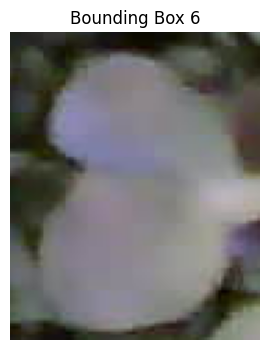

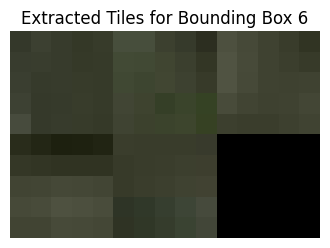

Pigment values for Bounding Box 6: [     5.2274      4.5266      15.595     0.50764]


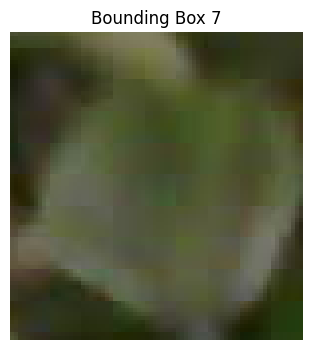

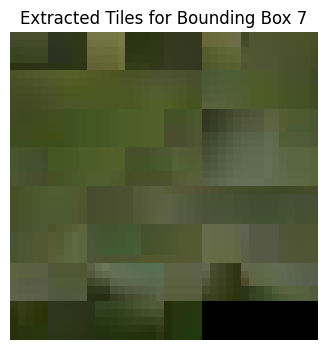

Pigment values for Bounding Box 7: [     5.3189      4.4834      18.041     0.46298]


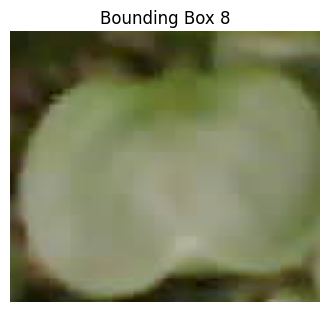

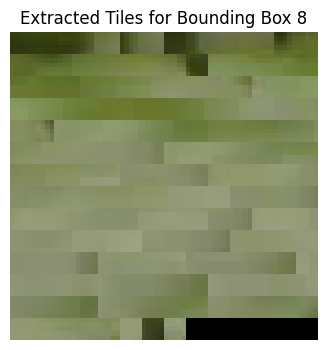

Pigment values for Bounding Box 8: [     4.7886      5.3913      1.2217     0.96764]


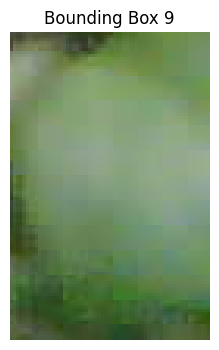

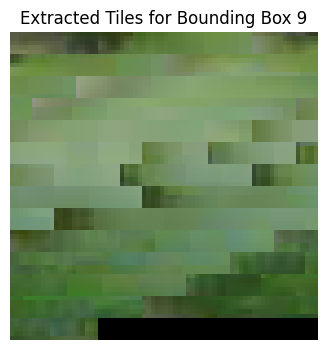

Pigment values for Bounding Box 9: [      4.846      5.4782      1.2774     0.96603]


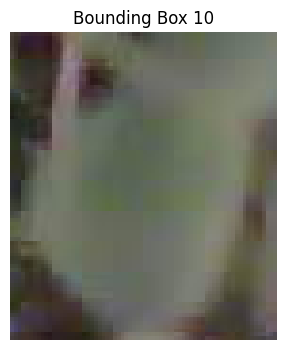

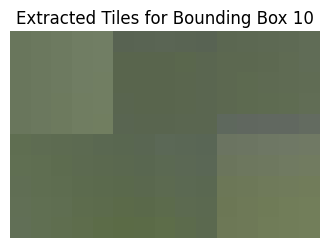

Pigment values for Bounding Box 10: [     2.9538      3.3607      1.0197     0.73949]


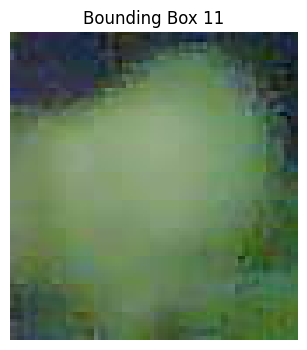

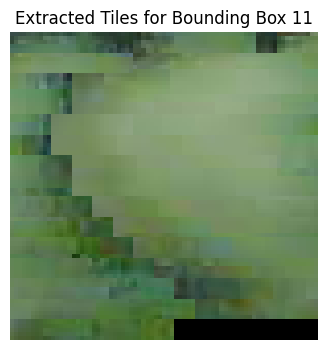

Pigment values for Bounding Box 11: [     4.4241      5.0318      1.4066     0.89135]


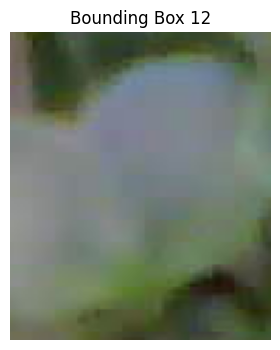

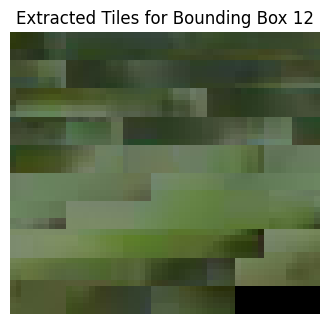

Pigment values for Bounding Box 12: [     5.6314      4.4436      21.986     0.42266]


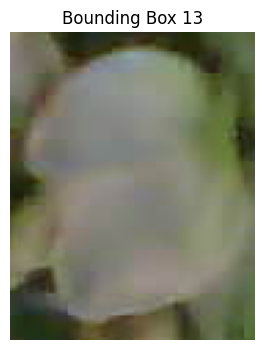

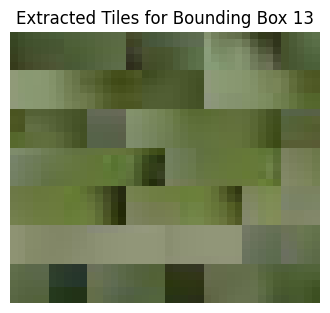

Pigment values for Bounding Box 13: [     4.3883      5.0146      1.7148     0.83218]


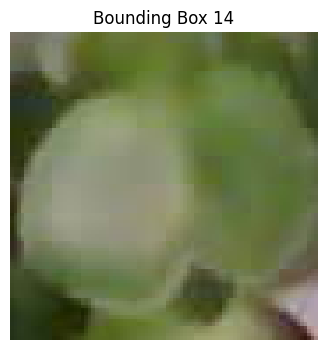

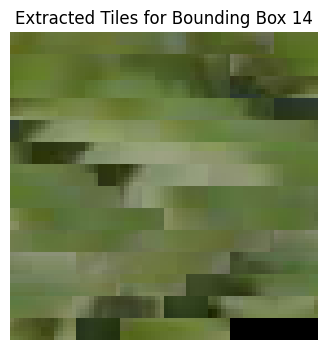

Pigment values for Bounding Box 14: [       5.32      5.9812      1.2696      1.0289]


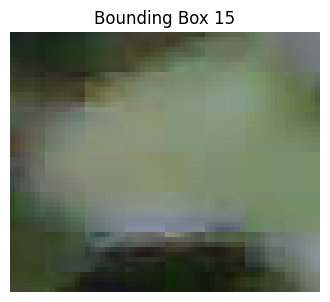

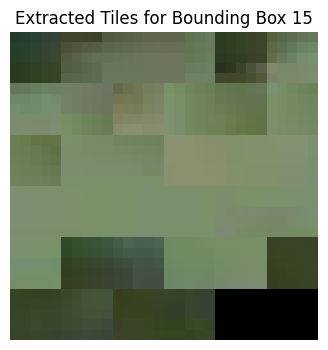

Pigment values for Bounding Box 15: [     5.1327      5.7806       1.272       1.005]


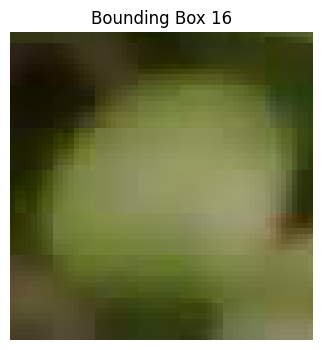

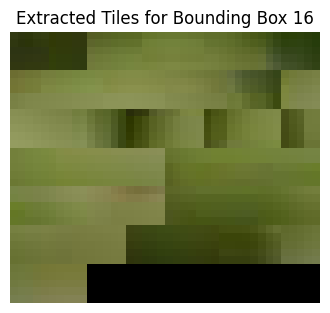

Pigment values for Bounding Box 16: [     5.2615      4.6415      15.756     0.48547]


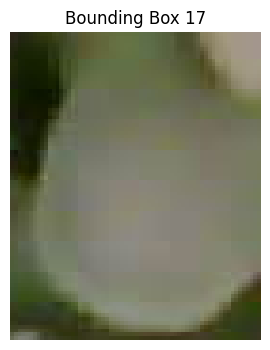

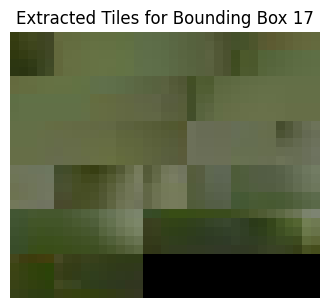

Pigment values for Bounding Box 17: [     5.6739      4.6833      19.773     0.45923]


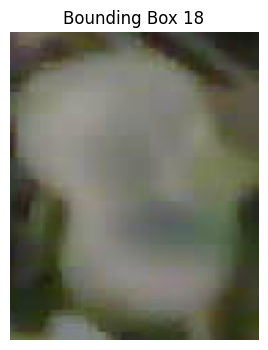

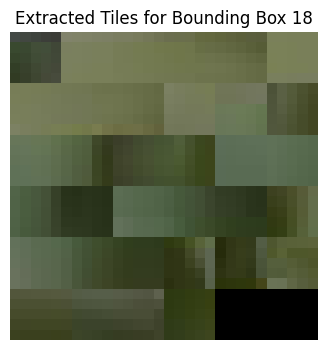

Pigment values for Bounding Box 18: [     5.9506        4.82      21.186     0.48725]


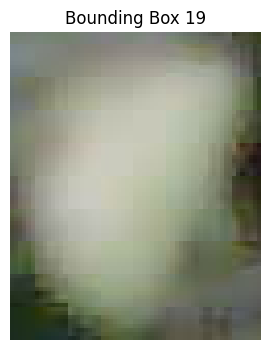

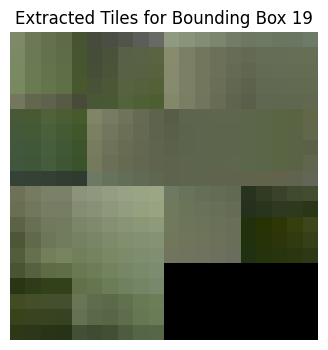

Pigment values for Bounding Box 19: [     5.0645      5.5895      4.9487     0.90152]


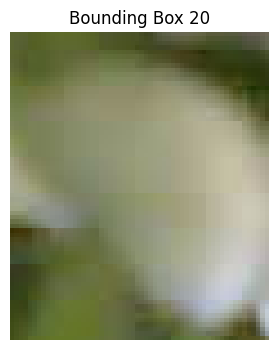

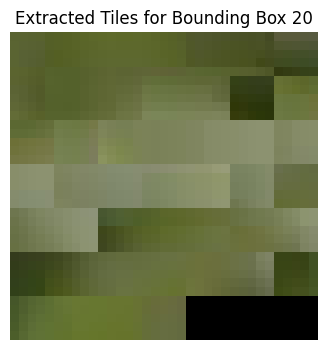

Pigment values for Bounding Box 20: [     5.3766      6.0528      1.2308      1.0444]


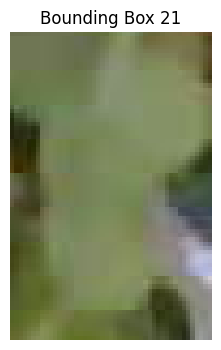

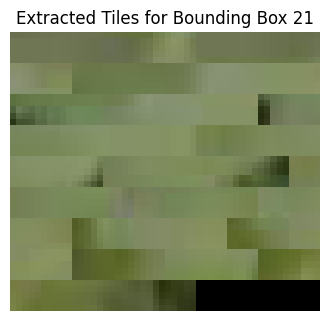

Pigment values for Bounding Box 21: [     4.7339      5.3535      1.2601     0.95459]


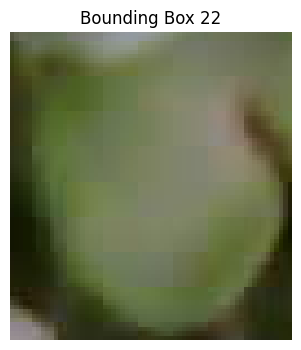

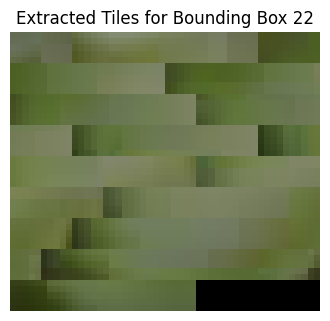

Pigment values for Bounding Box 22: [     5.0137      5.6508       1.327       0.978]


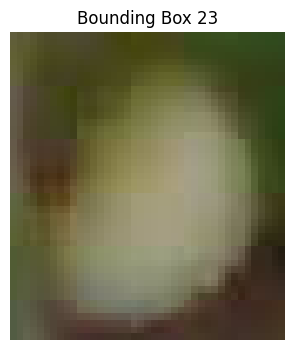

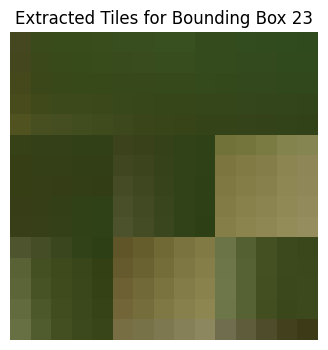

Pigment values for Bounding Box 23: [     5.4971      4.6691      18.397     0.47589]


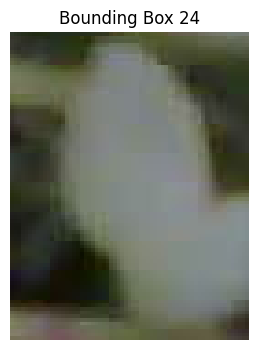

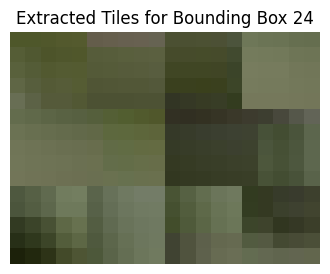

Pigment values for Bounding Box 24: [     5.7826      4.6882      20.155     0.45944]


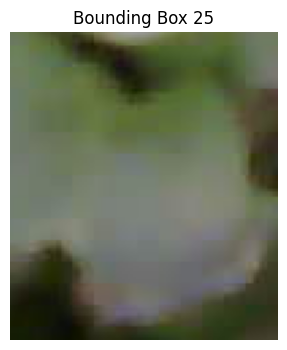

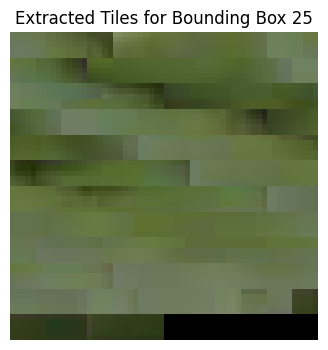

Pigment values for Bounding Box 25: [     5.3432      6.1784      2.7609      1.0799]


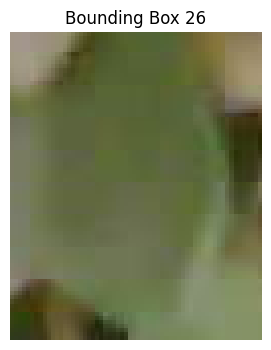

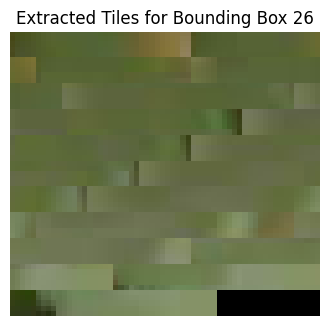

Pigment values for Bounding Box 26: [     4.9648      5.6022       1.338     0.96906]


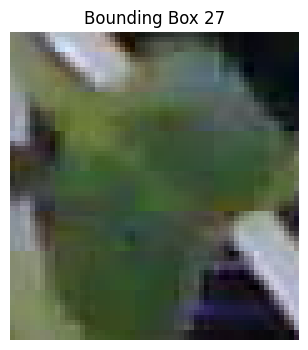

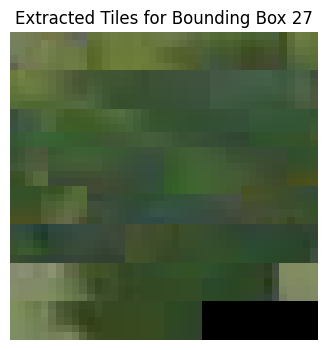

Pigment values for Bounding Box 27: [     5.3976      4.6252      17.326     0.48831]


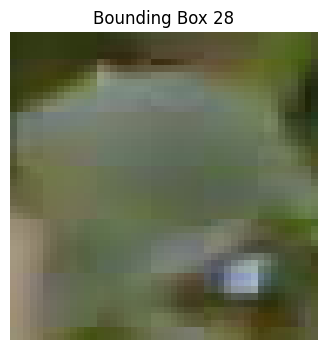

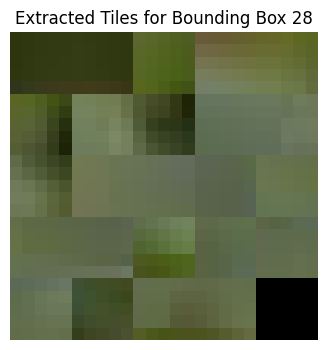

Pigment values for Bounding Box 28: [     4.8658      5.4998      2.7936     0.96139]


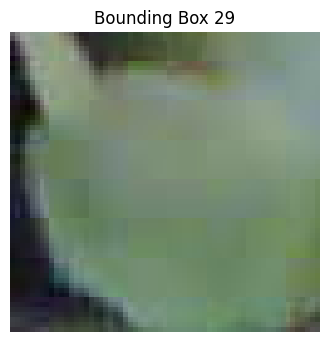

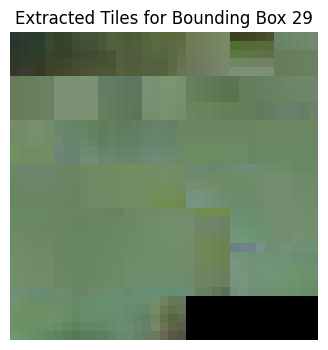

Pigment values for Bounding Box 29: [     4.8554      5.4753      1.1969     0.98173]


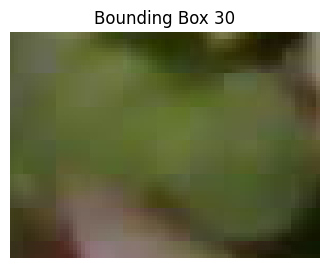

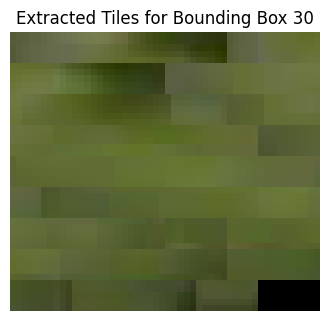

Pigment values for Bounding Box 30: [     5.6786      4.5953      20.469     0.43937]


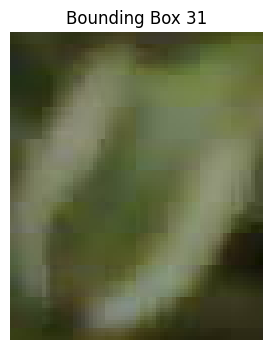

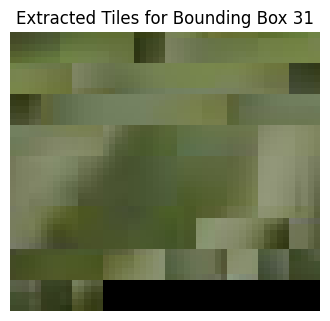

Pigment values for Bounding Box 31: [     4.5908      5.1851      1.9747     0.85678]


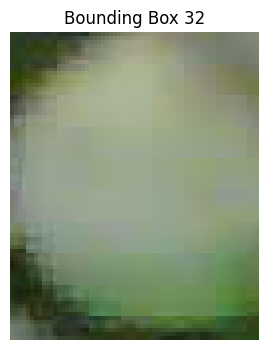

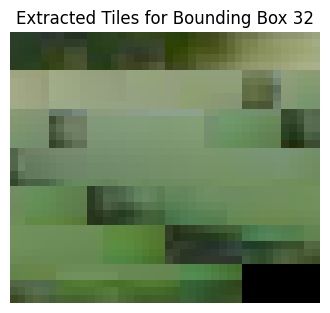

Pigment values for Bounding Box 32: [     4.8298      5.4731      1.3455     0.95273]


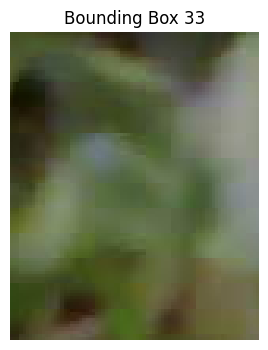

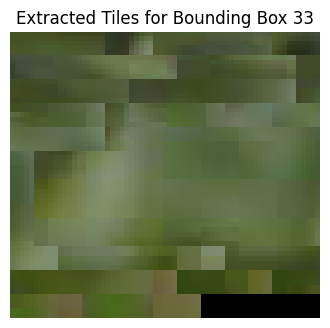

Pigment values for Bounding Box 33: [     5.1804      5.2293      9.8776     0.75426]


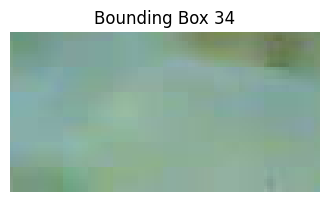

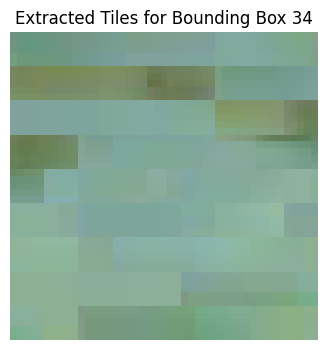

Pigment values for Bounding Box 34: [     2.9538      3.3607      1.0197     0.73949]


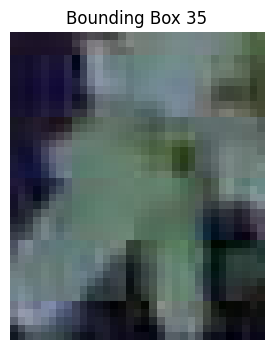

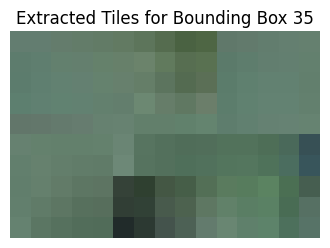

Pigment values for Bounding Box 35: [     3.7765      4.2902        1.39     0.80948]


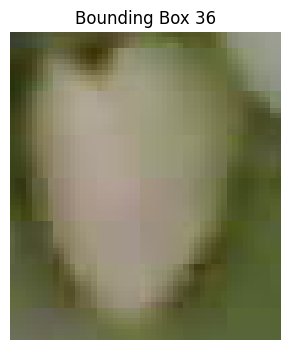

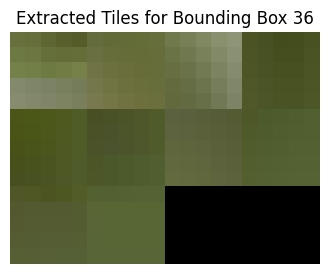

Pigment values for Bounding Box 36: [     5.8334      4.8122      20.999     0.50059]


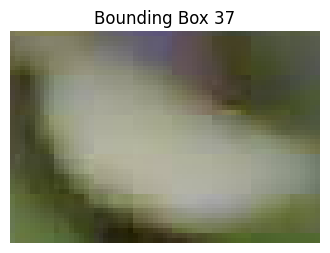

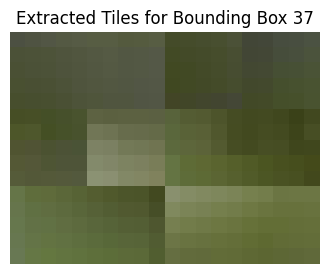

Pigment values for Bounding Box 37: [     5.5771      4.5563      19.479     0.43024]


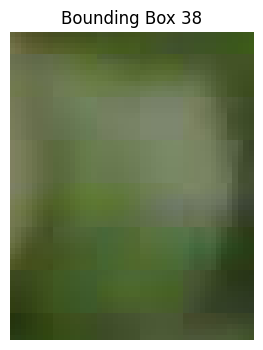

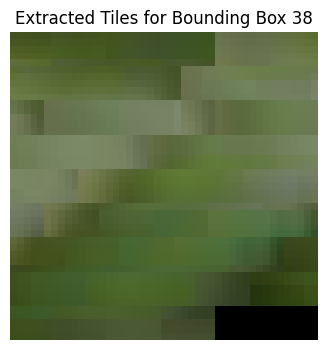

Pigment values for Bounding Box 38: [     5.0886      5.7975      1.5042     0.98769]


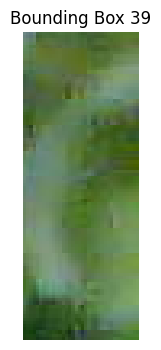

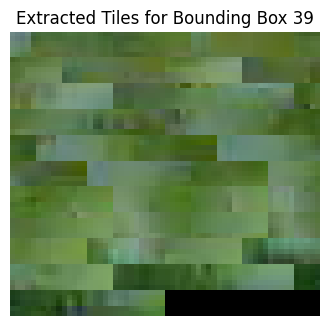

Pigment values for Bounding Box 39: [     4.7285      5.3728       1.414     0.92756]


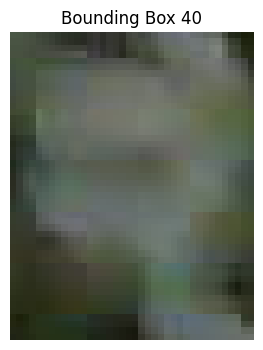

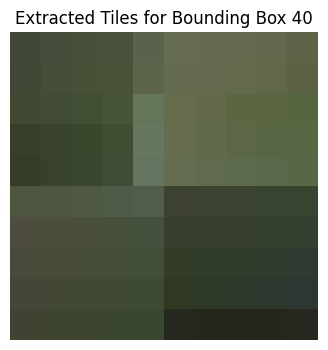

Pigment values for Bounding Box 40: [      5.825       4.725      21.422     0.47637]


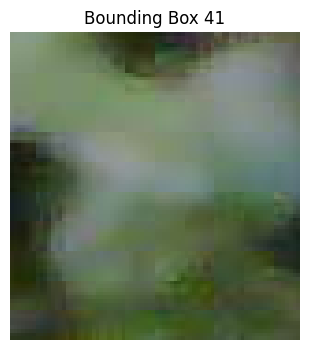

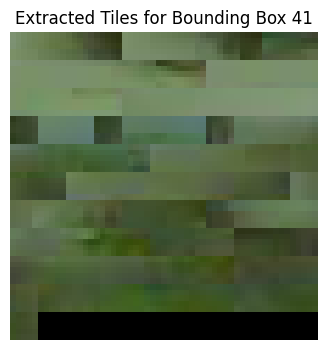

Pigment values for Bounding Box 41: [     5.6717      4.6724      20.026     0.46376]


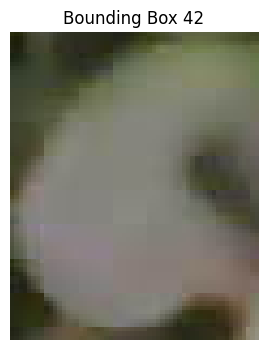

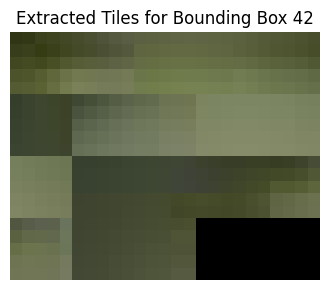

Pigment values for Bounding Box 42: [     5.9208       4.731      21.304     0.47854]


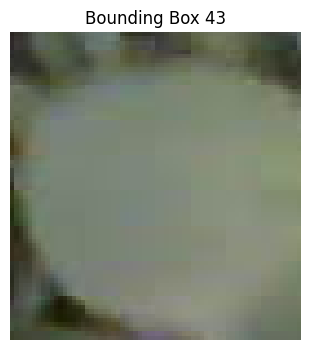

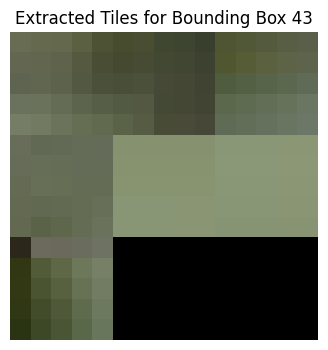

Pigment values for Bounding Box 43: [     5.7378      4.6501      21.434     0.45951]


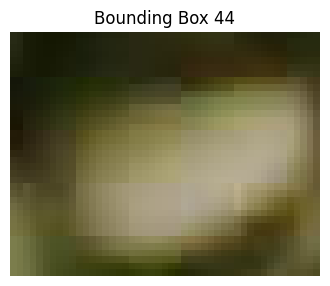

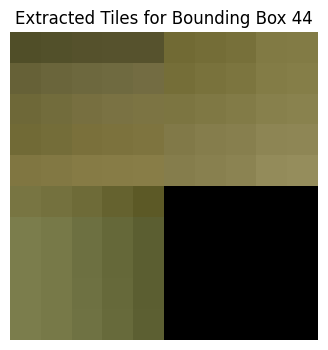

Pigment values for Bounding Box 44: [     5.8848       4.868       19.63     0.51104]


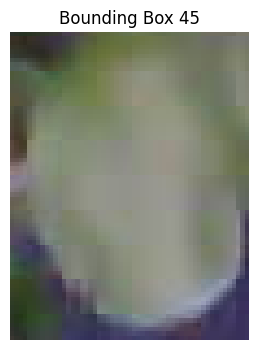

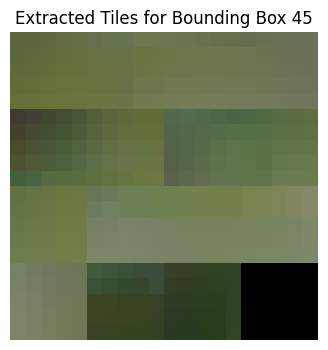

Pigment values for Bounding Box 45: [     5.1809      5.8342      1.1229       1.034]


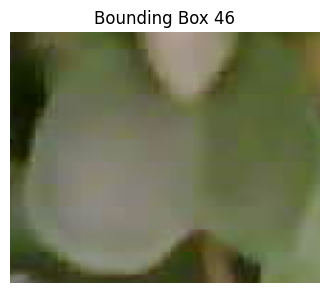

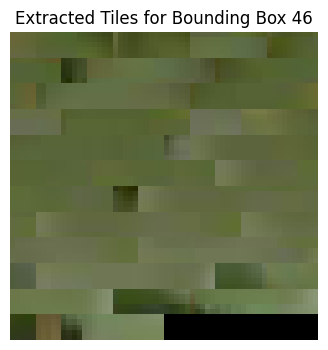

Pigment values for Bounding Box 46: [     4.8206      5.5074      2.2764     0.92707]


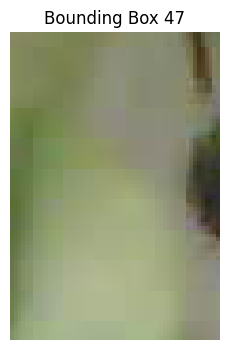

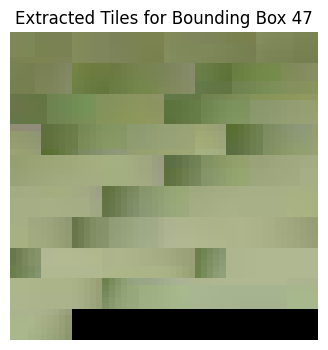

Pigment values for Bounding Box 47: [      4.883      5.4967      1.1711     0.98937]


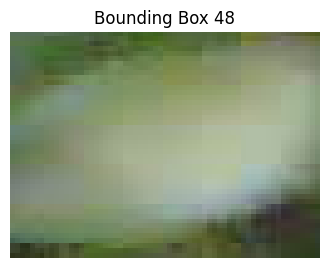

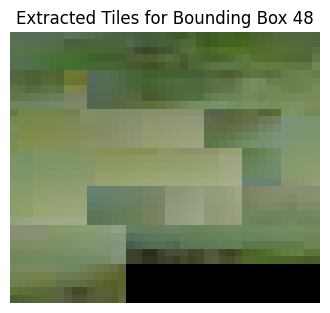

Pigment values for Bounding Box 48: [     5.1612      5.8097      1.1881      1.0233]


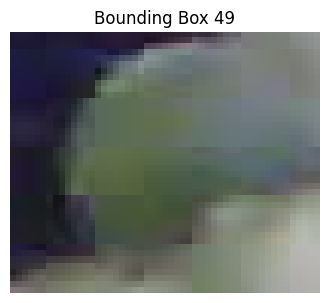

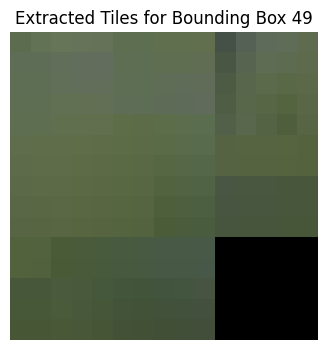

Pigment values for Bounding Box 49: [     5.1831      5.4736      5.6013     0.93637]


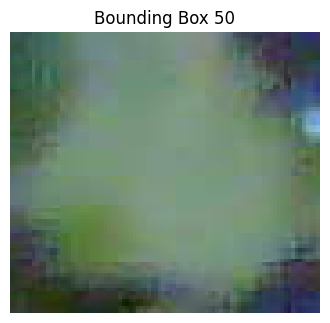

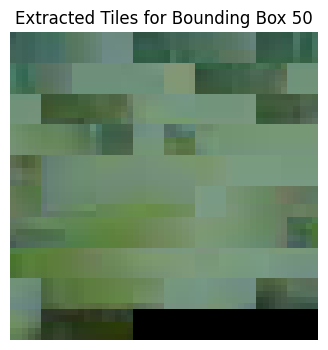

Pigment values for Bounding Box 50: [     5.2175      5.8543      1.1216      1.0402]


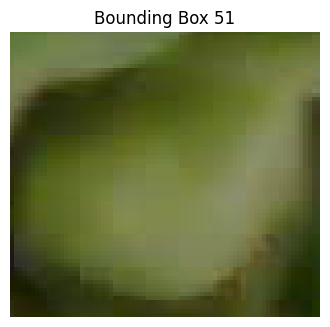

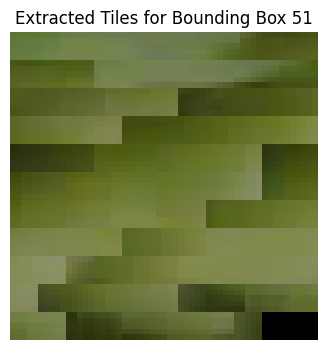

Pigment values for Bounding Box 51: [      4.967       4.781      11.814     0.57285]


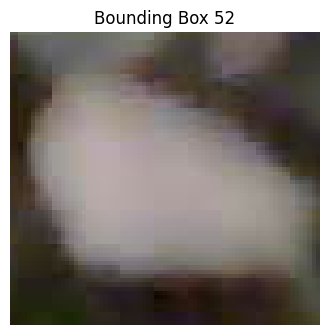

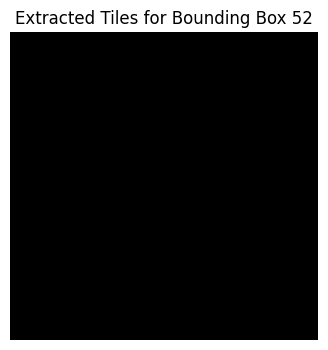

Pigment values for Bounding Box 52: [     5.3863       4.478      16.437     0.51177]


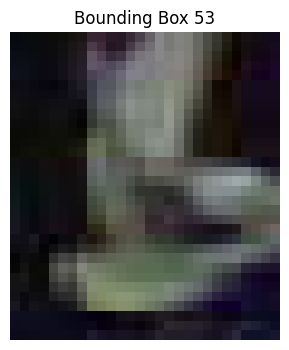

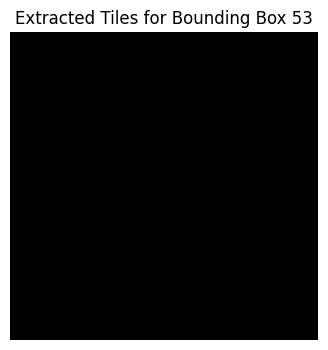

Pigment values for Bounding Box 53: [     5.3863       4.478      16.437     0.51177]


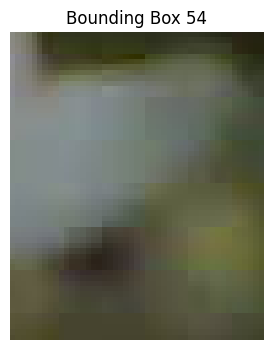

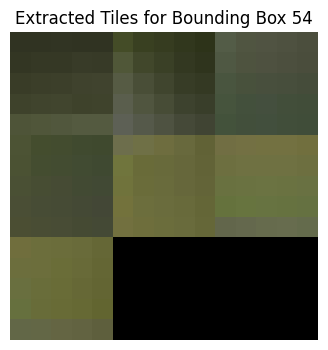

Pigment values for Bounding Box 54: [     5.5152       4.531      20.498     0.47887]


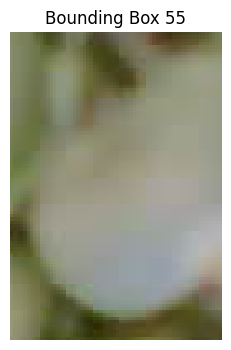

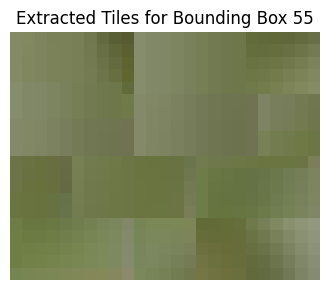

Pigment values for Bounding Box 55: [     2.9916      3.3975      1.0458     0.74024]


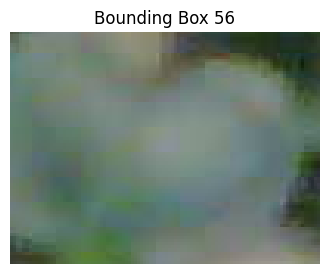

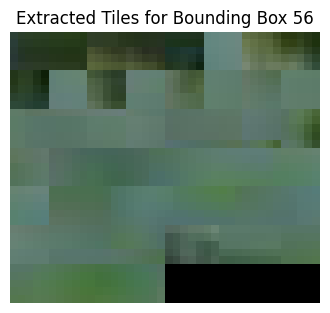

Pigment values for Bounding Box 56: [     5.3954      6.0459      1.1916      1.0515]


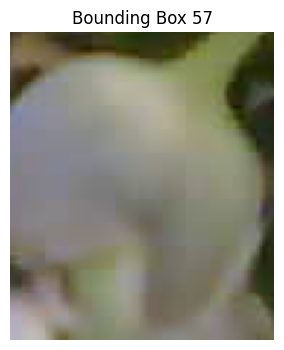

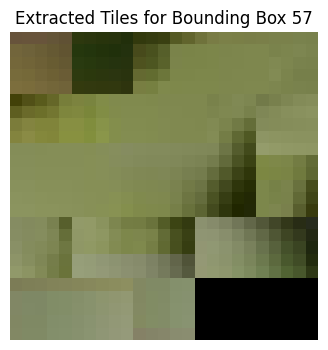

Pigment values for Bounding Box 57: [     5.0108      5.6711      1.3142     0.97985]


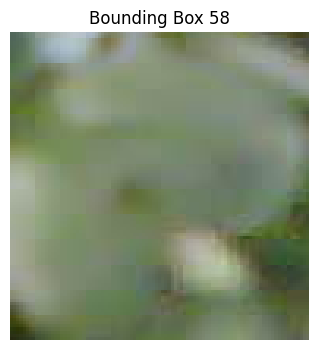

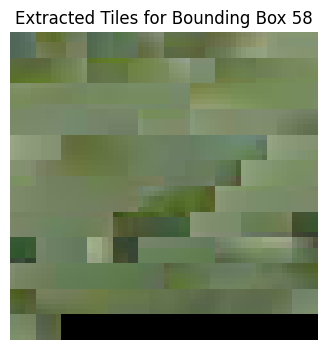

Pigment values for Bounding Box 58: [     4.7364      5.3577      1.2726     0.95304]


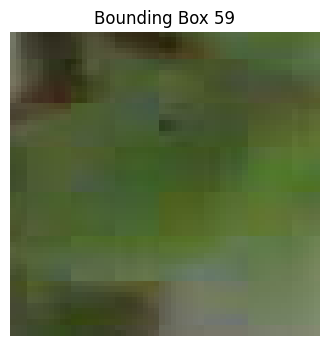

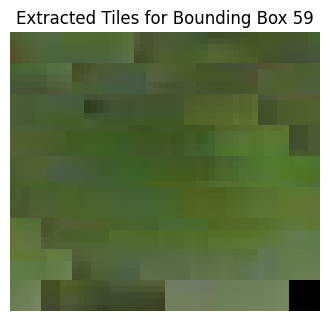

Pigment values for Bounding Box 59: [     5.7061      4.6763      19.875     0.45698]


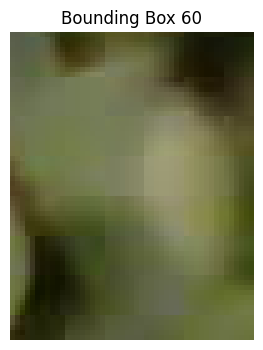

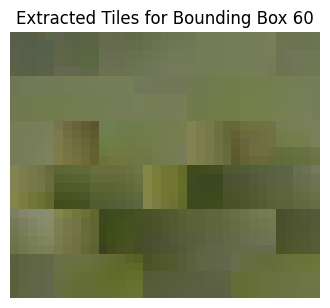

Pigment values for Bounding Box 60: [     4.5164      5.1387      1.4064     0.89778]


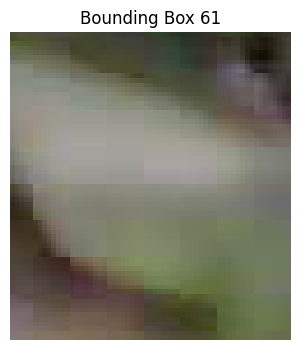

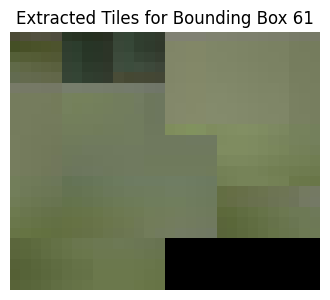

Pigment values for Bounding Box 61: [     5.1818      5.8334      1.1159      1.0358]


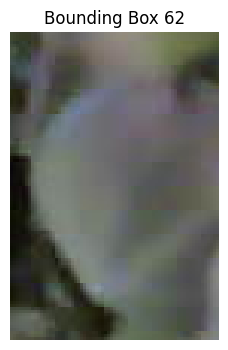

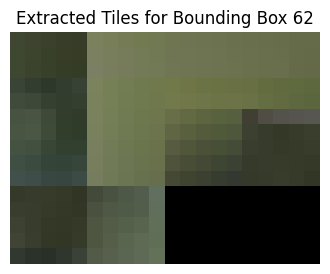

Pigment values for Bounding Box 62: [     5.8068      4.6842      22.245     0.46892]


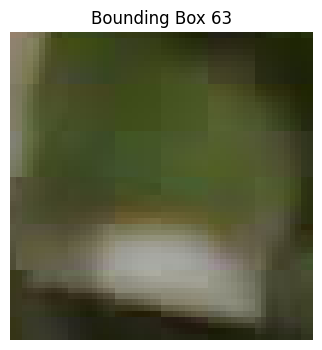

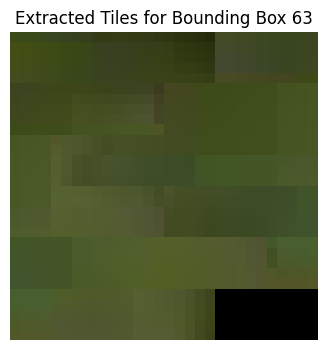

Pigment values for Bounding Box 63: [     5.2837      4.5383      16.639     0.48271]


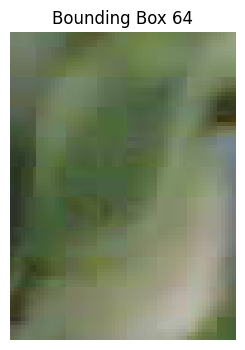

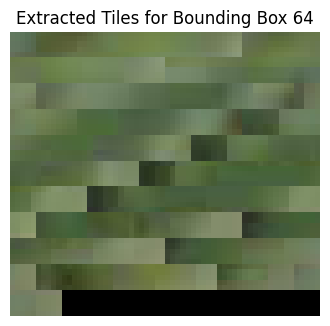

Pigment values for Bounding Box 64: [      5.451       4.662      16.836     0.46154]


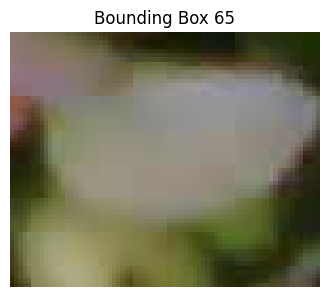

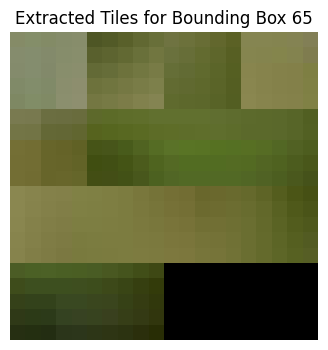

Pigment values for Bounding Box 65: [     5.6575      4.6292      20.303      0.4569]


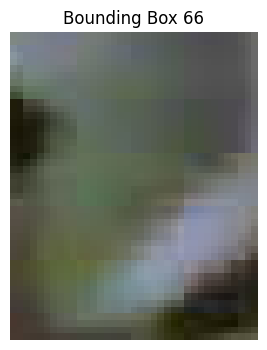

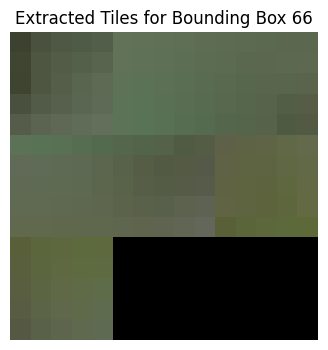

Pigment values for Bounding Box 66: [     5.8475      4.9159      19.396     0.51951]


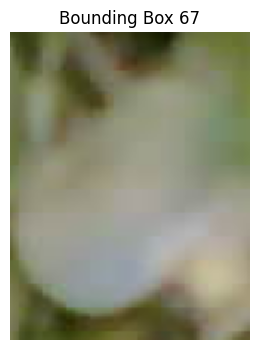

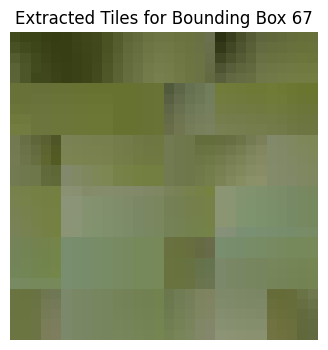

Pigment values for Bounding Box 67: [     4.2977      4.8753      1.3485     0.88839]


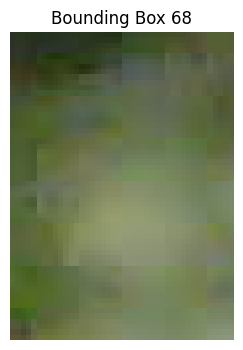

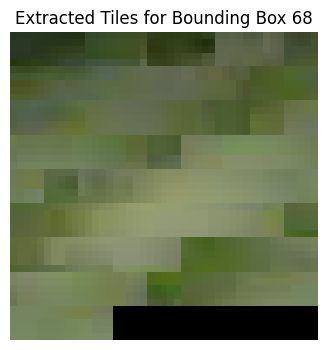

Pigment values for Bounding Box 68: [     5.3436      6.1311       1.604      1.0619]


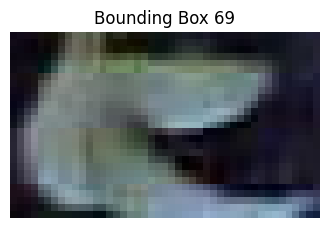

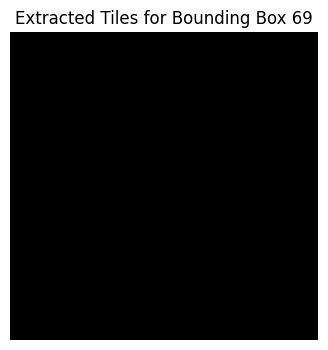

Pigment values for Bounding Box 69: [     5.3863       4.478      16.437     0.51177]


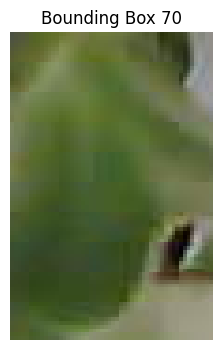

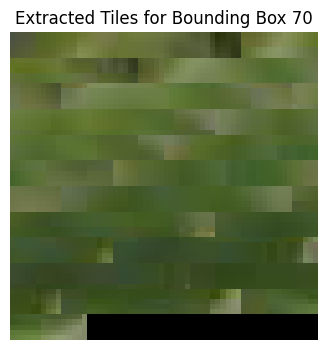

Pigment values for Bounding Box 70: [     5.5446      4.6698      19.245     0.46626]


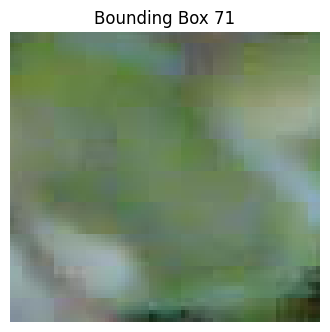

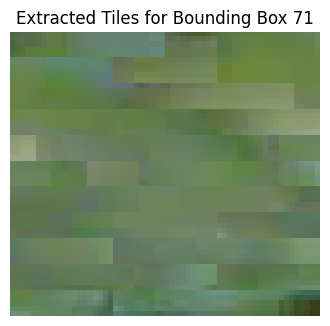

Pigment values for Bounding Box 71: [     2.9681      3.3756      1.0305     0.74005]


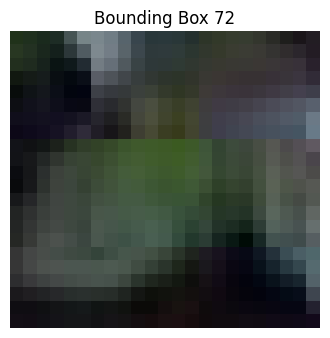

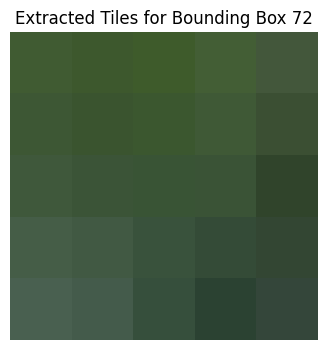

Pigment values for Bounding Box 72: [     5.4553      4.6769      17.673     0.47859]


In [ ]:
visualize_pigment_analysis()